[View in Colaboratory](https://colab.research.google.com/github/pmanlukas/colabSVM/blob/master/linear_classifier.ipynb)

# Linear Classifier
In this notebook a linear classifier based on a SVM is developed that is used as benchmark for the neural network based classifier

In [1]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8.1) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .

Processing triggers for libc-bin (2.26-0ubuntu2.1) ...
Setting up libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Setting up unattended-upgrades (0.98ubuntu1.1) ...

Creating config file /etc/apt/apt.conf.d/20auto-upgrades with new version

Creating config file /etc/apt/apt.conf.d/50unattended-upgrades with new version
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up dirmngr (2.1.15-1ubuntu8.1) ...
Setting up cron (3.0pl1-128ubuntu5) ...
Adding group `crontab' (GID 102) ...
Done.
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
update-rc.d: warning: stop runlevel arguments (1) do not match cron Default-Stop values (none)
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Setting up kmod (24-1ubuntu2) ...
Setting up libdbus-glib-1-2:amd64 (0.108-2) ...
Setting up python3-gi (3.24.1

In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [3]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

In [5]:
!ls /content/drive/openapi-data/

CNN_cat_eval.h5        glove.6B.zip		structure_labels0518.csv
CNN_cat.h5	       LSTMCNN_cat.h5		structure_labels.csv
CNN_cat_weights.h5     LSTMCNN_cat_weights.h5	tf_transformer.pickle
CNN_path.h5	       mnist.py			tokenizer_cat
CNN_path_weights.h5    new_path_labels0518.csv	tokenizer_path
CNN_struct.h5	       path_labels0518.csv	tokenizer_struct
CNN_struct_weights.h5  path_labels.csv		weights.best.hdf5
drive		       pickle			wordvector
encoder.pickle	       PoC Classifier Path.odt


In [0]:
import os
os.chdir("drive/openapi-data")

In [7]:
!ls

CNN_cat_eval.h5        glove.6B.zip		structure_labels0518.csv
CNN_cat.h5	       LSTMCNN_cat.h5		structure_labels.csv
CNN_cat_weights.h5     LSTMCNN_cat_weights.h5	tf_transformer.pickle
CNN_path.h5	       mnist.py			tokenizer_cat
CNN_path_weights.h5    new_path_labels0518.csv	tokenizer_path
CNN_struct.h5	       path_labels0518.csv	tokenizer_struct
CNN_struct_weights.h5  path_labels.csv		weights.best.hdf5
drive		       pickle			wordvector
encoder.pickle	       PoC Classifier Path.odt


In [0]:
import pickle

In [0]:
training_data = dict()

with open('pickle/specjson210518.pkl', 'rb') as handle:
    training_data = pickle.load(handle)

In [0]:
training_info = dict()

with open('pickle/infodict0518.pkl', 'rb') as handle:
    training_info = pickle.load(handle)

In [0]:
cat_data = dict()

with open('pickle/spec_category0518.pkl', 'rb') as handle:
    cat_data = pickle.load(handle)

In [12]:
cat_label = dict()

with open('pickle/categories_dict0518.pkl', 'rb') as handle:
    cat_label = pickle.load(handle)
    
print(cat_label)

{'1forge.com': 'financial', '6-dot-authentiqio.appspot.com': 'security', 'adafruit.com': 'iot', 'adobe.com:aem': 'marketing', 'adyen.com:CheckoutService': 'payment', 'adyen.com:PaymentService': 'payment', 'adyen.com:RecurringService': 'payment', 'afterbanks.com': 'financial', 'agco-ats.com': 'ecommerce', 'airport-web.appspot.com': 'transport', 'amazonaws.com:AWSMigrationHub': 'cloud', 'amazonaws.com:acm': 'cloud', 'amazonaws.com:acm-pca': 'cloud', 'amazonaws.com:alexaforbusiness': 'cloud', 'amazonaws.com:apigateway': 'cloud', 'amazonaws.com:application-autoscaling': 'cloud', 'amazonaws.com:appstream': 'cloud', 'amazonaws.com:appsync': 'cloud', 'amazonaws.com:athena': 'cloud', 'amazonaws.com:autoscaling': 'cloud', 'amazonaws.com:autoscaling-plans': 'cloud', 'amazonaws.com:batch': 'cloud', 'amazonaws.com:budgets': 'cloud', 'amazonaws.com:ce': 'cloud', 'amazonaws.com:cloud9': 'cloud', 'amazonaws.com:clouddirectory': 'cloud', 'amazonaws.com:cloudformation': 'cloud', 'amazonaws.com:cloudfro

In [13]:
cat_info = dict()
for cat in cat_data:
    info = cat_data[cat]['info']
    cat_info[cat] = info
print(cat_info.keys())

dict_keys(['1forge.com', '6-dot-authentiqio.appspot.com', 'adafruit.com', 'adobe.com:aem', 'adyen.com:CheckoutService', 'adyen.com:PaymentService', 'adyen.com:RecurringService', 'afterbanks.com', 'agco-ats.com', 'airport-web.appspot.com', 'amazonaws.com:AWSMigrationHub', 'amazonaws.com:acm', 'amazonaws.com:acm-pca', 'amazonaws.com:alexaforbusiness', 'amazonaws.com:apigateway', 'amazonaws.com:application-autoscaling', 'amazonaws.com:appstream', 'amazonaws.com:appsync', 'amazonaws.com:athena', 'amazonaws.com:autoscaling', 'amazonaws.com:autoscaling-plans', 'amazonaws.com:batch', 'amazonaws.com:budgets', 'amazonaws.com:ce', 'amazonaws.com:cloud9', 'amazonaws.com:clouddirectory', 'amazonaws.com:cloudformation', 'amazonaws.com:cloudfront', 'amazonaws.com:cloudhsm', 'amazonaws.com:cloudhsmv2', 'amazonaws.com:cloudsearch', 'amazonaws.com:cloudsearchdomain', 'amazonaws.com:cloudtrail', 'amazonaws.com:codebuild', 'amazonaws.com:codecommit', 'amazonaws.com:codedeploy', 'amazonaws.com:codepipelin

In [14]:
paths = dict()
for path in training_data:
    info = training_data[path]['paths']
    paths[path] = info
print(paths.keys())

dict_keys(['1forge.com', '6-dot-authentiqio.appspot.com', 'adafruit.com', 'adobe.com:aem', 'adyen.com:CheckoutService', 'adyen.com:PaymentService', 'adyen.com:RecurringService', 'afterbanks.com', 'agco-ats.com', 'airport-web.appspot.com', 'amadeus.com', 'amazonaws.com:AWSMigrationHub', 'amazonaws.com:acm', 'amazonaws.com:acm-pca', 'amazonaws.com:alexaforbusiness', 'amazonaws.com:apigateway', 'amazonaws.com:application-autoscaling', 'amazonaws.com:appstream', 'amazonaws.com:appsync', 'amazonaws.com:athena', 'amazonaws.com:autoscaling', 'amazonaws.com:autoscaling-plans', 'amazonaws.com:batch', 'amazonaws.com:budgets', 'amazonaws.com:ce', 'amazonaws.com:cloud9', 'amazonaws.com:clouddirectory', 'amazonaws.com:cloudformation', 'amazonaws.com:cloudfront', 'amazonaws.com:cloudhsm', 'amazonaws.com:cloudhsmv2', 'amazonaws.com:cloudsearch', 'amazonaws.com:cloudsearchdomain', 'amazonaws.com:cloudtrail', 'amazonaws.com:codebuild', 'amazonaws.com:codecommit', 'amazonaws.com:codedeploy', 'amazonaws.

In [0]:
keys = list(training_data.keys())

In [16]:
training_data[keys[0]]

{'basePath': '/forex-quotes',
 'host': '1forge.com',
 'info': {'contact': {'email': 'contact@1forge.com',
   'name': '1Forge',
   'url': 'http://1forge.com'},
  'description': 'Stock and Forex Data and Realtime Quotes',
  'title': '1Forge Finance APIs',
  'version': '0.0.1',
  'x-apisguru-categories': ['financial'],
  'x-logo': {'backgroundColor': '#24292e',
   'url': 'https://api.apis.guru/v2/cache/logo/http_1forge.com_logo.png'},
  'x-origin': [{'format': 'swagger',
    'url': 'http://1forge.com/openapi.json',
    'version': '2.0'}],
  'x-preferred': True,
  'x-providerName': '1forge.com'},
 'paths': {'/quotes': {'get': {'description': 'Get quotes',
    'externalDocs': {'description': 'Find out more',
     'url': 'http://1forge.com/forex-data-api'},
    'responses': {'200': {'description': 'A list of quotes'}},
    'summary': 'Get quotes for all symbols',
    'tags': ['forex', 'finance', 'quotes']}},
  '/symbols': {'get': {'description': 'Symbol List',
    'externalDocs': {'descripti

In [0]:
from collections import Counter
from datetime import datetime
 
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [0]:
labelsP = pd.read_csv("path_labels0518.csv").values
labelsS  = pd.read_csv("structure_labels0518.csv").values
labelsPP = pd.read_csv("new_path_labels0518.csv").values

In [19]:
texts = []   # list of text samples
for spec in training_data:
  strJson = json.dumps(training_data[spec])
  texts.append(strJson)

print(str(len(texts)))

1034


In [20]:
#turn info objects into strings

texts_info= []   # list of text samples
for info in training_info:
  strJson = json.dumps(training_info[info])
  texts_info.append(strJson)

print(str(len(texts_info)))

1034


In [21]:
texts_paths = []   # list of text samples
for path_obj in paths:
  strJson = json.dumps(paths[path_obj])
  texts_paths.append(strJson)

print(str(len(texts_paths)))

1034


In [22]:
cat_texts = []   # list of text samples
for cat in cat_data:
  stringg = json.dumps(cat_data[cat])
  cat_texts.append(stringg)

print(str(len(cat_texts)))

944


In [23]:
#turn info objects into strings

texts_info_cat = []   # list of text samples
for cat in cat_info:
  strJson = json.dumps(cat_info[cat])
  texts_info_cat.append(strJson)

print(str(len(texts_info_cat)))

944


In [24]:
labelsPath = list()
labelsPath3 = list()
labelsStruct = list()
labelsCat = list()

for labs in labelsS:
  labelsStruct.append(labs[1])

for labp in labelsP:
  labelsPath.append(labp[1])

for labp in labelsPP:
  labelsPath3.append(labp[1])
  
for labc in cat_label:
  labelsCat.append(cat_label[labc])
  
print(str(len(labelsPath)))
print(str(len(labelsPath3)))
print(str(len(labelsStruct)))
print(str(len(labelsCat)))

1034
1034
1034
944


In [0]:
from sklearn.model_selection import train_test_split

#split the data and labels into a test and train set
X_trainS, X_testS, y_trainS, y_testS = train_test_split(texts, labelsStruct, test_size=0.3, random_state=0)

In [0]:
#split the data and labels into a test and train set
X_trainP, X_testP, y_trainP, y_testP = train_test_split(texts, labelsPath3, test_size=0.3, random_state=0)

In [0]:
#split for category texts and labels
X_trainC, X_testC, y_trainC, y_testC = train_test_split(cat_texts, labelsCat, test_size=0.3, random_state=0)

In [0]:
#split for info texts and labels
X_trainI, X_testI, y_trainI, y_testI = train_test_split(texts_info_cat, labelsCat, test_size=0.3, random_state=0)

In [0]:
#split for path_obj texts and labels
X_trainPP, X_testPP, y_trainPP, y_testPP = train_test_split(texts_paths, labelsPath3, test_size=0.3, random_state=0)

In [0]:
from sklearn import model_selection, preprocessing, linear_model

#encoder for labels of category
encoder = preprocessing.LabelEncoder()
enc = preprocessing.LabelEncoder().fit(labelsCat)

with open('encoder.pickle', 'wb') as fin:
  pickle.dump(enc, fin)


y_trainC = encoder.fit_transform(y_trainC)
y_testC = encoder.fit_transform(y_testC)

y_trainI = encoder.fit_transform(y_trainI)
y_testI = encoder.fit_transform(y_testI)

In [31]:
enc.inverse_transform([11])

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['financial'], dtype='<U17')

In [32]:
y_testC

array([ 2, 24,  1,  2,  2,  2,  7, 13,  2,  2,  2,  2,  2,  2,  2,  5,  2,
        2, 16, 12, 15,  2,  2, 12,  2,  3, 12,  2, 22,  2,  2,  6, 19,  2,
        2,  2,  2,  2, 12, 19, 18,  2, 19,  2,  2, 12,  2,  3,  2, 15,  2,
        0, 15,  2,  2,  2,  2,  2, 10,  2, 12, 22,  2,  3,  2, 11, 21, 15,
        7,  2,  2, 15, 21,  6,  2,  6,  7,  2,  2, 15, 23,  2, 21,  2,  6,
       15,  2, 15,  2,  2,  2,  2, 24,  0, 18, 12, 12,  4, 12,  2,  6,  2,
        3,  2,  1,  4, 12, 13,  2,  2, 12,  2, 15,  2, 15,  2, 21, 19,  2,
        2, 12,  2,  3,  2,  2,  2, 19, 15,  2, 13, 10,  2,  3, 15,  2,  4,
        2, 22,  2, 15,  2,  2,  2,  5, 18,  2,  2,  2, 15, 16,  2, 23,  2,
        7, 19, 13,  2,  2,  2,  2,  2,  2,  2,  2,  4,  2,  6,  2,  8,  0,
       22,  3,  2,  2,  2,  7,  2,  2, 15,  2,  2,  3, 20,  2,  2,  2,  2,
        2,  1,  7,  2, 15,  2,  3,  9,  2,  9,  6,  4,  2,  6,  2,  7,  2,
        2,  6,  9,  2,  2, 14, 18, 24,  2,  2,  2,  2,  2,  2,  2,  6,  2,
        2,  6,  2,  2,  2

## model architecture

the first model is for structure labels

In [0]:
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
 

In [0]:
#vectorizer based on TF-IDF
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

tf_transformer = vectorizer.fit(texts)

with open('tf_transformer.pickle', 'wb') as fin:
  pickle.dump(tf_transformer, fin)

In [0]:
#Classifiers, Naive Bayes and linear SVM based
clfSVC = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=15, random_state=42)

clfNB = MultinomialNB()

### The following model is for the structure

In [36]:
  
t1 = datetime.now()


#fit to vectorizer
XtrainS = tf_transformer.transform(X_trainS)
XtestS = tf_transformer.transform(X_testS)


print(datetime.now() - t1)
print(XtrainS.shape)

#fit model to data
model_svm = clfSVC.fit(XtrainS, y_trainS)
model_nb = clfNB.fit(XtrainS, y_trainS)

#cross validation
score_svm = cross_val_score(model_svm, XtrainS, y_trainS, cv=10, n_jobs=-1)
score_nb = cross_val_score(model_nb, XtrainS, y_trainS, cv=10, n_jobs=-1)
 
print(datetime.now() - t1)
print("CV of SVM:")
print(score_svm)
print(sum(score_svm) / len(score_svm))
print("CV of nb:")
print(score_nb)
print(sum(score_nb) / len(score_nb))

0:00:14.267943
(723, 49606)
0:00:19.249259
CV of SVM:
[0.81818182 0.74666667 0.82432432 0.79452055 0.73611111 0.75
 0.78873239 0.85714286 0.84285714 0.73913043]
0.789766729737793
CV of nb:
[0.64935065 0.68       0.60810811 0.57534247 0.61111111 0.65277778
 0.61971831 0.65714286 0.67142857 0.60869565]
0.6333675502705568


In [37]:
score = model_svm.score(XtestS, y_testS)
print(score)

0.7395498392282959


In [38]:
score = model_nb.score(XtestS, y_testS)
print(score)

0.5530546623794212


In [0]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [41]:
y_pred = cross_val_predict(model_svm,XtestS,y_testS,cv=10)
print(classification_report(y_testS, y_pred))
print(accuracy_score(y_testS, y_pred))
conf_mat = confusion_matrix(y_testS,y_pred)
conf_mat

             precision    recall  f1-score   support

          1       0.45      0.57      0.50        30
          2       0.64      0.41      0.50        22
          3       0.57      0.64      0.60        47
          4       0.47      0.57      0.51        35
          5       0.94      0.79      0.86        39
          6       0.89      0.65      0.75        37
          7       0.86      0.97      0.91        63
          8       0.91      0.76      0.83        38

avg / total       0.73      0.71      0.71       311

0.7106109324758842


array([[17,  1,  6,  6,  0,  0,  0,  0],
       [ 2,  9,  5,  3,  0,  0,  0,  3],
       [10,  1, 30,  5,  0,  1,  0,  0],
       [ 6,  0,  7, 20,  2,  0,  0,  0],
       [ 1,  1,  2,  4, 31,  0,  0,  0],
       [ 0,  0,  1,  2,  0, 24, 10,  0],
       [ 0,  0,  0,  0,  0,  2, 61,  0],
       [ 2,  2,  2,  3,  0,  0,  0, 29]])

Normalized confusion matrix
[[0.56666667 0.03333333 0.2        0.2        0.         0.
  0.         0.        ]
 [0.09090909 0.40909091 0.22727273 0.13636364 0.         0.
  0.         0.13636364]
 [0.21276596 0.0212766  0.63829787 0.10638298 0.         0.0212766
  0.         0.        ]
 [0.17142857 0.         0.2        0.57142857 0.05714286 0.
  0.         0.        ]
 [0.02564103 0.02564103 0.05128205 0.1025641  0.79487179 0.
  0.         0.        ]
 [0.         0.         0.02702703 0.05405405 0.         0.64864865
  0.27027027 0.        ]
 [0.         0.         0.         0.         0.         0.03174603
  0.96825397 0.        ]
 [0.05263158 0.05263158 0.05263158 0.07894737 0.         0.
  0.         0.76315789]]


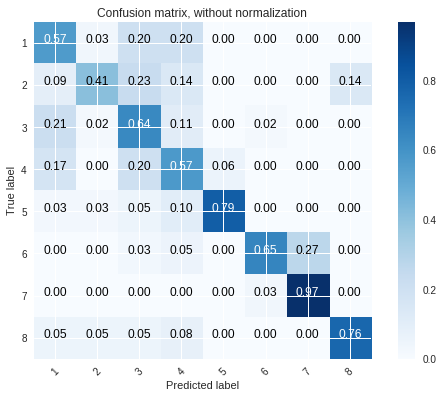

In [42]:
plt.figure()
plot_confusion_matrix(conf_mat, classes=[1,2,3,4,5,6,7,8], normalize=True,
                      title='Confusion matrix, without normalization')

In [42]:
y_pred = cross_val_predict(model_nb,XtestS,y_testS,cv=10)
print(classification_report(y_testS, y_pred))
print(accuracy_score(y_testS, y_pred))
conf_mat = confusion_matrix(y_testS,y_pred)
conf_mat

             precision    recall  f1-score   support

          1       0.00      0.00      0.00        30
          2       0.00      0.00      0.00        22
          3       0.47      0.60      0.52        47
          4       1.00      0.29      0.44        35
          5       1.00      0.79      0.89        39
          6       1.00      0.16      0.28        37
          7       0.39      1.00      0.56        63
          8       0.71      0.79      0.75        38

avg / total       0.59      0.54      0.48       311

0.5401929260450161


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[ 0,  0,  9,  0,  0,  0, 21,  0],
       [ 0,  0,  4,  0,  0,  0,  7, 11],
       [ 0,  0, 28,  0,  0,  0, 19,  0],
       [ 0,  0, 12, 10,  0,  0, 13,  0],
       [ 0,  0,  1,  0, 31,  0,  6,  1],
       [ 0,  0,  2,  0,  0,  6, 29,  0],
       [ 0,  0,  0,  0,  0,  0, 63,  0],
       [ 0,  0,  4,  0,  0,  0,  4, 30]])

Normalized confusion matrix
[[0.         0.         0.3        0.         0.         0.
  0.7        0.        ]
 [0.         0.         0.18181818 0.         0.         0.
  0.31818182 0.5       ]
 [0.         0.         0.59574468 0.         0.         0.
  0.40425532 0.        ]
 [0.         0.         0.34285714 0.28571429 0.         0.
  0.37142857 0.        ]
 [0.         0.         0.02564103 0.         0.79487179 0.
  0.15384615 0.02564103]
 [0.         0.         0.05405405 0.         0.         0.16216216
  0.78378378 0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.        ]
 [0.         0.         0.10526316 0.         0.         0.
  0.10526316 0.78947368]]


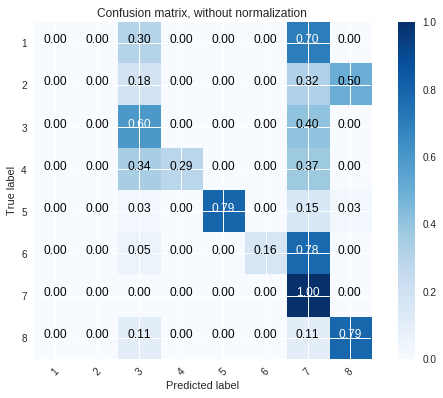

In [43]:
plt.figure()
plot_confusion_matrix(conf_mat, classes=[1,2,3,4,5,6,7,8], normalize=True,
                      title='Confusion matrix, without normalization')

### The following model is created for the paths label

In [44]:
  
t1 = datetime.now()



XtrainP = tf_transformer.transform(X_trainP)
XtestP = tf_transformer.transform(X_testP)


print(datetime.now() - t1)
print(XtrainP.shape)

model_svm_P = clfSVC.fit(XtrainP, y_trainP)
model_nb_P = clfNB.fit(XtrainP, y_trainP)

#cross validation
score_svm_P = cross_val_score(model_svm_P, XtrainP, y_trainP, cv=10, n_jobs=-1)
score_nb_P = cross_val_score(model_nb_P, XtrainP, y_trainP, cv=10, n_jobs=-1)
 
print(datetime.now() - t1)
print("CV of SVM:")
print(score_svm_P)
print(sum(score_svm_P) / len(score_svm_P))
print("CV of nb:")
print(score_nb_P)
print(sum(score_nb_P) / len(score_nb_P))

0:00:12.284476
(723, 49606)
0:00:15.766825
CV of SVM:
[0.78378378 0.66216216 0.82432432 0.75342466 0.69863014 0.78873239
 0.69014085 0.70422535 0.67605634 0.69014085]
0.7271620839438706
CV of nb:
[0.59459459 0.62162162 0.71621622 0.60273973 0.56164384 0.76056338
 0.74647887 0.63380282 0.5915493  0.61971831]
0.6448928670132607


             precision    recall  f1-score   support

          1       0.79      0.79      0.79       103
          2       0.66      0.56      0.61       112
          3       0.68      0.80      0.74        96

avg / total       0.71      0.71      0.71       311

0.7106109324758842
Normalized confusion matrix
[[0.78640777 0.14563107 0.06796117]
 [0.17857143 0.5625     0.25892857]
 [0.02083333 0.17708333 0.80208333]]


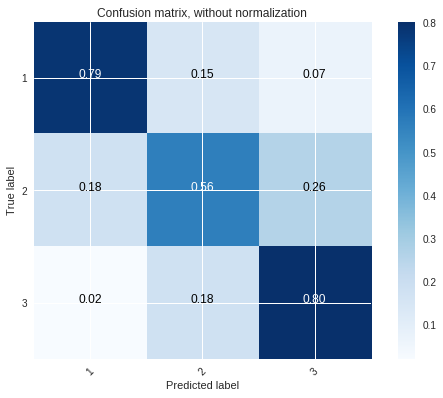

In [45]:
y_pred = cross_val_predict(model_svm_P,XtestP,y_testP,cv=10)
print(classification_report(y_testP, y_pred))
print(accuracy_score(y_testP, y_pred))
conf_mat = confusion_matrix(y_testP,y_pred)
conf_mat
plt.figure()
plot_confusion_matrix(conf_mat, classes=[1,2,3], normalize=True,
                      title='Confusion matrix, without normalization')

In [46]:

t1 = datetime.now()



XtrainPP = tf_transformer.transform(X_trainPP)
XtestPP = tf_transformer.transform(X_testPP)


print(datetime.now() - t1)
print(XtrainP.shape)

model_svm_P = clfSVC.fit(XtrainPP, y_trainPP)
model_nb_P = clfNB.fit(XtestPP, y_testPP)

#cross validation
score_svm_P = cross_val_score(model_svm_P, XtrainPP, y_trainPP, cv=10, n_jobs=-1)
score_nb_P = cross_val_score(model_nb_P, XtrainPP, y_trainPP, cv=10, n_jobs=-1)
 
print(datetime.now() - t1)
print("CV of SVM:")
print(score_svm_P)
print(sum(score_svm_P) / len(score_svm_P))
print("CV of nb:")
print(score_nb_P)
print(sum(score_nb_P) / len(score_nb_P))

0:00:06.818278
(723, 49606)
0:00:09.524882
CV of SVM:
[0.68918919 0.68918919 0.81081081 0.68493151 0.69863014 0.71830986
 0.73239437 0.66197183 0.71830986 0.69014085]
0.7093877593588186
CV of nb:
[0.56756757 0.55405405 0.68918919 0.57534247 0.54794521 0.63380282
 0.56338028 0.56338028 0.63380282 0.57746479]
0.5905929467959179


             precision    recall  f1-score   support

          1       0.75      0.73      0.74       103
          2       0.58      0.53      0.55       112
          3       0.65      0.74      0.69        96

avg / total       0.66      0.66      0.66       311

0.6591639871382636
Normalized confusion matrix
[[0.72815534 0.18446602 0.08737864]
 [0.20535714 0.52678571 0.26785714]
 [0.02083333 0.23958333 0.73958333]]


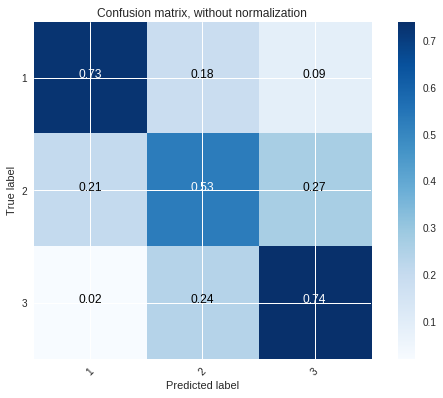

In [47]:
y_pred = cross_val_predict(model_svm_P,XtestPP,y_testPP,cv=10)
print(classification_report(y_testPP, y_pred))
print(accuracy_score(y_testPP, y_pred))
conf_mat = confusion_matrix(y_testPP,y_pred)
conf_mat
plt.figure()
plot_confusion_matrix(conf_mat, classes=[1,2,3], normalize=True,
                      title='Confusion matrix, without normalization')

### the following model is created for the category input

In [48]:
  
t1 = datetime.now()

clfSVC = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=15, random_state=42)
clfNB = MultinomialNB()

#fit to vectorizer
XtrainC = tf_transformer.transform(X_trainC)
XtestC = tf_transformer.transform(X_testC)


print(datetime.now() - t1)
print(XtrainC.shape)

#fit model to data
model_svm_c = clfSVC.fit(XtrainC, y_trainC)
model_nb_c = clfNB.fit(XtrainC, y_trainC)

#cross validation
score_svm_C = cross_val_score(model_svm, XtrainC, y_trainC, cv=10, n_jobs=-1)
score_nb_C = cross_val_score(model_nb, XtrainC, y_trainC, cv=10, n_jobs=-1)
 
print(datetime.now() - t1)
print("CV of SVM:")
print(score_svm_C)
print(sum(score_svm_C) / len(score_svm_C))
print("CV of nb:")
print(score_nb_C)
print(sum(score_nb_C) / len(score_nb_C))

0:00:11.475350
(660, 49606)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


0:00:20.192026
CV of SVM:
[0.67901235 0.75949367 0.78378378 0.78082192 0.75714286 0.84375
 0.85245902 0.83636364 0.90566038 0.88      ]
0.8078487605415517
CV of nb:
[0.45679012 0.49367089 0.51351351 0.50684932 0.52857143 0.5625
 0.59016393 0.63636364 0.71698113 0.7       ]
0.5705403969551514


In [49]:
  
t1 = datetime.now()

clfSVC = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=15, random_state=42)
clfNB = MultinomialNB()

#fit to vectorizer
XtrainI = tf_transformer.transform(X_trainI)
XtestI = tf_transformer.transform(X_testI)


print(datetime.now() - t1)
print(XtrainC.shape)

#fit model to data
model_svm_c = clfSVC.fit(XtrainI, y_trainI)
model_nb_c = clfNB.fit(XtrainI, y_trainI)

#cross validation
score_svm_C = cross_val_score(model_svm_c, XtrainI, y_trainI, cv=10, n_jobs=-1)
score_nb_C = cross_val_score(model_nb_c, XtrainI, y_trainI, cv=10, n_jobs=-1)
 
print(datetime.now() - t1)
print("CV of SVM:")
print(score_svm_C)
print(sum(score_svm_C) / len(score_svm_C))
print("CV of nb:")
print(score_nb_C)
print(sum(score_nb_C) / len(score_nb_C))

0:00:00.229794
(660, 49606)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


0:00:04.344169
CV of SVM:
[0.87654321 0.91139241 0.94594595 1.         0.98571429 0.96875
 1.         1.         1.         1.        ]
0.9688345846600066
CV of nb:
[0.44444444 0.46835443 0.47297297 0.49315068 0.51428571 0.5625
 0.59016393 0.63636364 0.66037736 0.68      ]
0.5522613176294817


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00         3
          1       0.00      0.00      0.00         3
          2       0.82      0.97      0.89       150
          3       0.38      0.25      0.30        12
          4       0.00      0.00      0.00         7
          5       1.00      0.33      0.50         3
          6       1.00      0.93      0.96        14
          7       0.46      0.67      0.55         9
          8       0.00      0.00      0.00         1
          9       0.00      0.00      0.00         4
         10       0.00      0.00      0.00         2
         11       0.00      0.00      0.00         1
         12       0.57      0.71      0.63        17
         13       1.00      0.25      0.40         4
         14       0.00      0.00      0.00         1
         15       0.60      0.83      0.70        18
         16       0.00      0.00      0.00         2
         17       0.00      0.00      0.00   

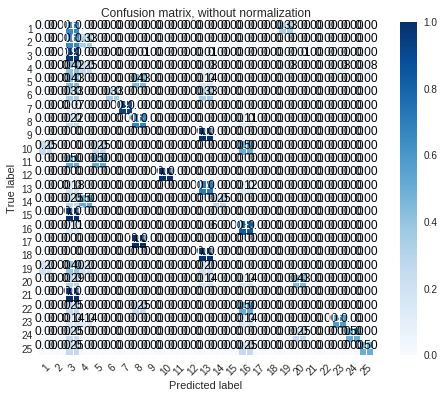

In [50]:
y_pred = cross_val_predict(model_svm_c,XtestC,y_testI,cv=10)
print(classification_report(y_testI, y_pred))
print(accuracy_score(y_testI, y_pred))
conf_mat = confusion_matrix(y_testI,y_pred)
conf_mat
plt.figure()
plot_confusion_matrix(conf_mat, classes=list(range(1,26)), normalize=True,
                      title='Confusion matrix, without normalization')

## package the model

In [0]:
from sklearn.externals import joblib

In [52]:
joblib.dump(model_svm, "pickle/model_svm.pickle")


['pickle/model_svm.pickle']

In [53]:
joblib.dump(model_svm_P, "pickle/model_svm_P.pickle")

['pickle/model_svm_P.pickle']

In [54]:
joblib.dump(model_svm_c, "pickle/model_svm_C.pickle")

['pickle/model_svm_C.pickle']